# 데이터 준비하기

In [ ]:
from google.colab import drive

In [ ]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


코랩에서 konlpy를 사용하기 위한 처리

In [ ]:
!apt-get update

!apt-get install g++ openjdk-8-jdk python-dev python3-dev

!pip3 install JPype1-py3

!pip3 install konlpy

!JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from konlpy.tag import Okt

데이터 불러오기

In [ ]:
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Naver text DATA/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Naver text DATA/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [35]:
X_train.shape

(146182, 41)

In [37]:
y_train.shape

(146182,)

In [36]:
X_test.shape

(49157, 41)

In [38]:
y_test.shape

(49157,)



---



# 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

코랩에서 Mecab을 사용하기 위한 처리

In [ ]:
! git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

fatal: destination path 'Mecab-ko-for-Google-Colab' already exists and is not an empty directory.


In [ ]:
 cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [ ]:
! bash install_mecab-ko_on_colab190912.sh

In [ ]:
from konlpy.tag import Mecab

In [ ]:
mecab = Mecab()

In [24]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [25]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [26]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]



---



# 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포

In [27]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [28]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.969355837799927
문장길이 최대 :  116
문장길이 표준편차 :  12.843536204665021


- 적절한 최대 문장 길이 지정 | maxlen : 41

In [29]:
# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


- keras.preprocessing.sequence.pad_sequences을 활용한 패딩 추가

In [30]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)




---



#Validation Set 구성, 모델구성, 모델훈련 및 테스트

Validation Set 구성

약 14만개의 train 데이터에서 5분의 2인 56000개를 validation set으로 사용

In [41]:
# validation set 56000건 분리
X_val = X_train[:56000]   
y_val = y_train[:56000]

# validation set을 제외한 나머지 56000건
partial_X_train = X_train[56000:]  
partial_y_train = y_train[56000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(90182, 41)
(90182,)


##1. RNN (Recurrent Neural Network)

모델구성

In [40]:
vocab_size = 56000  # 어휘 사전의 크기입니다
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          896000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 896,881
Trainable params: 896,881
Non-trainable params: 0
_________________________________________________________________


모델훈련

In [42]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
177/177 [==============================] - 12s 53ms/step - loss: 0.5897 - accuracy: 0.6820 - val_loss: 0.4453 - val_accuracy: 0.8229
Epoch 2/10
177/177 [==============================] - 9s 49ms/step - loss: 0.3913 - accuracy: 0.8439 - val_loss: 0.3859 - val_accuracy: 0.8356
Epoch 3/10
177/177 [==============================] - 9s 49ms/step - loss: 0.3363 - accuracy: 0.8661 - val_loss: 0.3649 - val_accuracy: 0.8436
Epoch 4/10
177/177 [==============================] - 9s 48ms/step - loss: 0.3172 - accuracy: 0.8736 - val_loss: 0.3639 - val_accuracy: 0.8433
Epoch 5/10
177/177 [==============================] - 9s 48ms/step - loss: 0.3048 - accuracy: 0.8798 - val_loss: 0.3681 - val_accuracy: 0.8420
Epoch 6/10
177/177 [==============================] - 9s 48ms/step - loss: 0.2958 - accuracy: 0.8829 - val_loss: 0.3841 - val_accuracy: 0.8371
Epoch 7/10
177/177 [==============================] - 8s 48ms/step - loss: 0.2879 - accuracy: 0.8857 - val_loss: 0.3770 - val_accuracy: 0.838

Loss, Accuracy 그래프 시각화

In [43]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


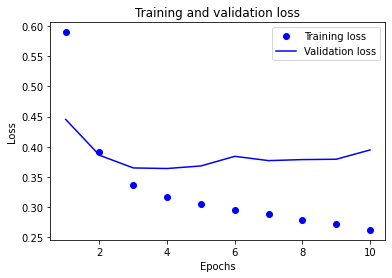

In [44]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

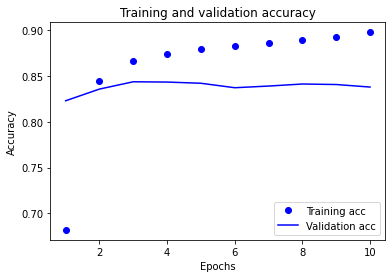

In [45]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델테스트

In [46]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4046 - accuracy: 0.8324
[0.40461933612823486, 0.8323941826820374]


##2. 1-D CNN(1-D Convolution Neural Network)

모델구성

In [49]:
vocab_size = 56000  # 어휘 사전의 크기입니다
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          896000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

모델훈련

In [50]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
177/177 [==============================] - 8s 43ms/step - loss: 0.5505 - accuracy: 0.7019 - val_loss: 0.3782 - val_accuracy: 0.8354
Epoch 2/10
177/177 [==============================] - 7s 41ms/step - loss: 0.3453 - accuracy: 0.8528 - val_loss: 0.3532 - val_accuracy: 0.8469
Epoch 3/10
177/177 [==============================] - 7s 41ms/step - loss: 0.3048 - accuracy: 0.8740 - val_loss: 0.3526 - val_accuracy: 0.8471
Epoch 4/10
177/177 [==============================] - 7s 42ms/step - loss: 0.2764 - accuracy: 0.8885 - val_loss: 0.3562 - val_accuracy: 0.8484
Epoch 5/10
177/177 [==============================] - 7s 39ms/step - loss: 0.2479 - accuracy: 0.9025 - val_loss: 0.3665 - val_accuracy: 0.8476
Epoch 6/10
177/177 [==============================] - 7s 40ms/step - loss: 0.2173 - accuracy: 0.9174 - val_loss: 0.3880 - val_accuracy: 0.8421
Epoch 7/10
177/177 [==============================] - 8s 43ms/step - loss: 0.1846 - accuracy: 0.9331 - val_loss: 0.4140 - val_accuracy: 0.8386

Loss, Accuracy 그래프 시각화

In [51]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


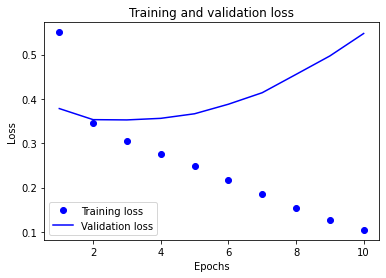

In [52]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

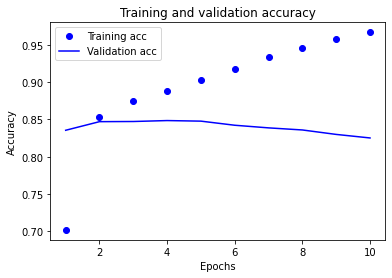

In [53]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델테스트

In [54]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5529 - accuracy: 0.8247
[0.5528682470321655, 0.8247248530387878]


## 3. GlobalMaxPooling1D()

모델구성

In [55]:
vocab_size = 56000  # 어휘 사전의 크기입니다
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          896000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 896,145
Trainable params: 896,145
Non-trainable params: 0
_________________________________________________________________


모델훈련

In [56]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
177/177 [==============================] - 5s 19ms/step - loss: 0.6321 - accuracy: 0.7245 - val_loss: 0.5030 - val_accuracy: 0.8073
Epoch 2/10
177/177 [==============================] - 3s 17ms/step - loss: 0.4160 - accuracy: 0.8297 - val_loss: 0.3816 - val_accuracy: 0.8324
Epoch 3/10
177/177 [==============================] - 3s 18ms/step - loss: 0.3441 - accuracy: 0.8539 - val_loss: 0.3626 - val_accuracy: 0.8387
Epoch 4/10
177/177 [==============================] - 3s 18ms/step - loss: 0.3105 - accuracy: 0.8702 - val_loss: 0.3585 - val_accuracy: 0.8424
Epoch 5/10
177/177 [==============================] - 3s 18ms/step - loss: 0.2863 - accuracy: 0.8822 - val_loss: 0.3607 - val_accuracy: 0.8426
Epoch 6/10
177/177 [==============================] - 3s 17ms/step - loss: 0.2666 - accuracy: 0.8923 - val_loss: 0.3666 - val_accuracy: 0.8426
Epoch 7/10
177/177 [==============================] - 3s 18ms/step - loss: 0.2500 - accuracy: 0.9004 - val_loss: 0.3739 - val_accuracy: 0.8416

Loss, Accuracy 그래프 시각화

In [57]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


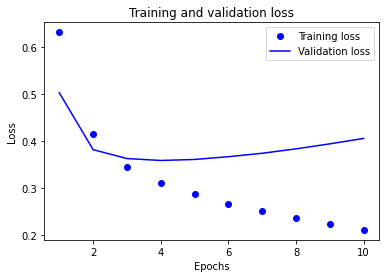

In [58]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

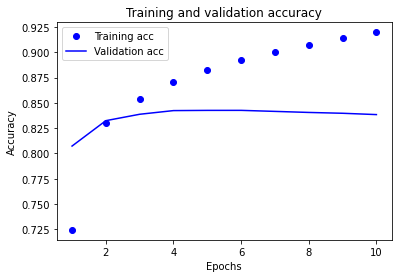

In [59]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델테스트

In [60]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.4140 - accuracy: 0.8357
[0.4139859676361084, 0.8356897234916687]


##4.Word Embedding(Word2Vec)

비용 절감과 정확도를 향상시킬 수 있는 자연어처리 기법 (단어의 특성을 저차원 벡터값으로 표현)

In [65]:
from gensim.models import KeyedVectors
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/Naver text DATA/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [67]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

모델구성

In [68]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

모델학습

In [71]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
177/177 [==============================] - 56s 313ms/step - loss: 0.5916 - accuracy: 0.6756 - val_loss: 0.4374 - val_accuracy: 0.8022
Epoch 2/10
177/177 [==============================] - 55s 312ms/step - loss: 0.3947 - accuracy: 0.8263 - val_loss: 0.3718 - val_accuracy: 0.8352
Epoch 3/10
177/177 [==============================] - 55s 310ms/step - loss: 0.3373 - accuracy: 0.8564 - val_loss: 0.3621 - val_accuracy: 0.8417
Epoch 4/10
177/177 [==============================] - 56s 315ms/step - loss: 0.3051 - accuracy: 0.8728 - val_loss: 0.3604 - val_accuracy: 0.8437
Epoch 5/10
177/177 [==============================] - 57s 320ms/step - loss: 0.2782 - accuracy: 0.8874 - val_loss: 0.3703 - val_accuracy: 0.8421
Epoch 6/10
177/177 [==============================] - 57s 320ms/step - loss: 0.2582 - accuracy: 0.8956 - val_loss: 0.4391 - val_accuracy: 0.8131
Epoch 7/10
177/177 [==============================] - 56s 318ms/step - loss: 0.2394 - accuracy: 0.9045 - val_loss: 0.4132 - val_ac

Loss, Accuracy 그래프 시각화

In [73]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


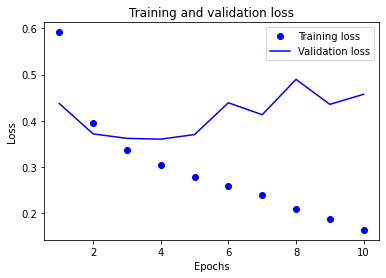

In [74]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

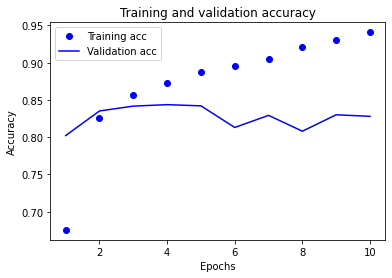

In [75]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델테스트

In [72]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 8s - loss: 0.4689 - accuracy: 0.8256
[0.4689459502696991, 0.8255996108055115]




---



#학습된 Embedding 레이어 분석

In [76]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 300)


In [78]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/Naver text DATA/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [80]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("love")

[('great', 0.6980192065238953),
 ('good', 0.6931933164596558),
 ('Good', 0.6513140797615051),
 ('♥', 0.6442612409591675),
 ('very', 0.5991372466087341),
 ('we', 0.5851877331733704),
 ('best', 0.5766173601150513),
 ('top', 0.5400000810623169),
 ('I', 0.517726480960846),
 ('^_^', 0.5030524730682373)]



---



#한국어 Word2Vec 임베딩 활용하여 성능개선

In [81]:
import gensim
from gensim.models import KeyedVectors
word2vec_path = '/content/drive/MyDrive/Colab Notebooks/Naver text DATA/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['강아지']
vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


array([ 0.28099054, -0.19049376,  0.31788886, -0.29404902, -0.6012117 ,
       -0.25619242,  0.0061479 ,  0.51780385,  0.3608627 , -0.27890292,
        0.3753059 ,  0.45682365,  0.25841945,  0.29509434,  0.31509322,
        0.53255475, -0.3150408 ,  0.28672394,  0.32292762, -0.11534653,
        0.24962434, -0.31804952,  0.02379435,  0.34782323, -0.5428502 ,
       -0.31428298,  0.81061304,  0.7245631 ,  0.04309795, -1.0204421 ,
        0.10398801,  0.2138965 ,  0.10057439, -0.03146021,  0.0894748 ,
       -0.40986905,  0.11873247,  0.2684793 , -0.6372648 ,  0.36586553,
       -0.15963972,  0.3209763 , -0.6995127 , -1.1059827 ,  0.37646636,
       -0.82615834,  0.12098166, -0.04935855, -0.5623957 ,  0.1068015 ,
        0.2640723 ,  0.6015352 ,  0.31571352, -0.37577182, -0.5941042 ,
        0.1046523 , -0.16794747,  0.36965755,  0.18888052, -0.18799411,
        0.13297085,  0.13900231, -0.25006363, -0.7406368 ,  0.1037019 ,
       -0.18334036, -0.17581826,  0.08528292, -0.07013045,  0.45

In [88]:
word2vec.similar_by_word('자동차')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('승용차', 0.729595422744751),
 ('스포츠카', 0.6468127965927124),
 ('오토바이', 0.6444642543792725),
 ('이륜차', 0.6432071328163147),
 ('자가용', 0.6401187777519226),
 ('경주용', 0.6348319053649902),
 ('미니밴', 0.6230480074882507),
 ('경차', 0.6184974908828735),
 ('현대자동차', 0.6122195720672607),
 ('자전거', 0.6117190718650818)]

모델구성

In [106]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [177]:
from tensorflow.keras.initializers import Constant
from keras.layers import Dense, Dropout

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(32, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 7, 16)             0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 1, 32)             3616      
_________________________________________________________________
global_max_pooling1d_17 (Glo (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 8)                 264       
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 8)               

모델학습

In [183]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
705/705 [==============================] - 104s 145ms/step - loss: 0.2205 - accuracy: 0.9198 - val_loss: 0.5789 - val_accuracy: 0.8335
Epoch 2/10
705/705 [==============================] - 109s 154ms/step - loss: 0.2158 - accuracy: 0.9228 - val_loss: 0.6120 - val_accuracy: 0.8370
Epoch 3/10
705/705 [==============================] - 109s 154ms/step - loss: 0.2110 - accuracy: 0.9248 - val_loss: 0.6586 - val_accuracy: 0.8363
Epoch 4/10
705/705 [==============================] - 117s 166ms/step - loss: 0.2061 - accuracy: 0.9269 - val_loss: 0.7680 - val_accuracy: 0.8340
Epoch 5/10
705/705 [==============================] - 103s 147ms/step - loss: 0.2035 - accuracy: 0.9275 - val_loss: 0.6614 - val_accuracy: 0.8318
Epoch 6/10
705/705 [==============================] - 110s 157ms/step - loss: 0.1970 - accuracy: 0.9297 - val_loss: 0.7064 - val_accuracy: 0.8318
Epoch 7/10
705/705 [==============================] - 112s 159ms/step - loss: 0.1937 - accuracy: 0.9316 - val_loss: 0.7270 -

In [189]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=300,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
301/301 [==============================] - 81s 265ms/step - loss: 0.1730 - accuracy: 0.9387 - val_loss: 0.8507 - val_accuracy: 0.8328
Epoch 2/10
301/301 [==============================] - 75s 249ms/step - loss: 0.1613 - accuracy: 0.9434 - val_loss: 0.9131 - val_accuracy: 0.8319
Epoch 3/10
301/301 [==============================] - 80s 264ms/step - loss: 0.1559 - accuracy: 0.9445 - val_loss: 0.8996 - val_accuracy: 0.8273
Epoch 4/10
301/301 [==============================] - 80s 267ms/step - loss: 0.1521 - accuracy: 0.9454 - val_loss: 0.8845 - val_accuracy: 0.8242
Epoch 5/10
301/301 [==============================] - 74s 247ms/step - loss: 0.1497 - accuracy: 0.9463 - val_loss: 0.9055 - val_accuracy: 0.8238
Epoch 6/10
301/301 [==============================] - 77s 257ms/step - loss: 0.1477 - accuracy: 0.9466 - val_loss: 0.9610 - val_accuracy: 0.8249
Epoch 7/10
301/301 [==============================] - 78s 259ms/step - loss: 0.1377 - accuracy: 0.9507 - val_loss: 1.0598 - val_ac

In [190]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Loss, Accuracy 그래프

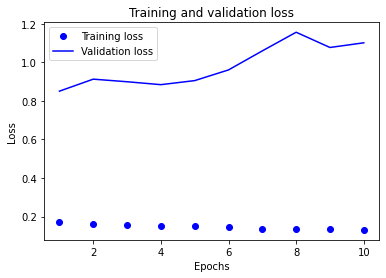

In [191]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

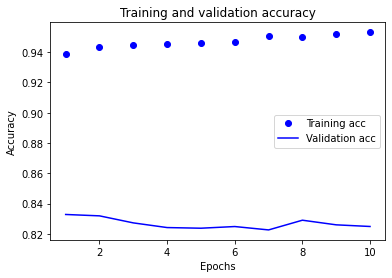

In [192]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

모델테스트

In [187]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.7779 - accuracy: 0.8193
[0.7779492735862732, 0.8193339705467224]


In [193]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 6s - loss: 1.1320 - accuracy: 0.8228
[1.131966471672058, 0.8228126168251038]




---



#회고



*   RNN 0.8324, 1-D CNN 0.8247, GlobalMaxPooling1D 0.8357, Word2Vec 0.8256, 한국어Word2Vec 0.8270
*   ==> GlobalMaxPooling1D, RNN, 한국어Word2Vec, Word2Vec, 1-D CNN 정확도 높음에서 낮음 순으로 정리
*   한국어Word2Vec으로 정확도 향상 시도
*   ==> 1. 0.8270 --> 0.8326 (Conv1D(32, 7, activation='relu'))

*   ==> 2. Optimizer를 여러 가지로 변경해 보았으나 개선 안 됨
*   ==> 3. 0.8331 (batch size 300으로 줄임)
*   Keras Tuner : 최적의 하이퍼파라미터 세트를 선택하는 데 도움을 주는 라이브러리가 있다는 것을 찾게 되었다.
*   Keras Tuner 사용법을 더 찾아보고, 다음에는 해당 라이브러리를 활용하여 하이퍼파라미터를 조정해 보고자 한다.